In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# setup working directory to a folder in Google Drive
import os 
root_dir = "/content/drive/My Drive/"
# set folder name (this folder should exist in 'root_dir')
project_folder = "multisensory_data/"

def set_working_directory(project_folder):
  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nYou can also run !pwd to confirm the current working directory." )

set_working_directory(project_folder)

Mounted at /content/drive

Your working directory was changed to /content/drive/My Drive/multisensory_data/

You can also run !pwd to confirm the current working directory.


# Import packages

In [ ]:
pip install jenkspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 495 kB 19.9 MB/s 


In [ ]:
from PIL import Image, ImageDraw, ImageFilter
import matplotlib
import re 
import os
from pathlib import Path
import statistics
import pandas as pd
import jenkspy

In [ ]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

In [ ]:
! wget https://raw.githubusercontent.com/nianticlabs/monodepth2/master/utils.py
! wget https://raw.githubusercontent.com/nianticlabs/monodepth2/master/networks/depth_decoder.py
! wget https://raw.githubusercontent.com/nianticlabs/monodepth2/master/networks/resnet_encoder.py
! wget https://raw.githubusercontent.com/nianticlabs/monodepth2/master/layers.py

--2022-11-15 19:03:43--  https://raw.githubusercontent.com/nianticlabs/monodepth2/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4314 (4.2K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   4.21K  --.-KB/s    in 0.001s  

2022-11-15 19:03:43 (3.95 MB/s) - ‘utils.py.1’ saved [4314/4314]

--2022-11-15 19:03:43--  https://raw.githubusercontent.com/nianticlabs/monodepth2/master/networks/depth_decoder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Savin

In [ ]:
from utils import download_model_if_doesnt_exist
from resnet_encoder import *
import layers
from depth_decoder import *

# Load model

In [ ]:
model_name = "mono+stereo_1024x320"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models/mono+stereo_1024x320.zip
   Unzipping model...
   Model unzipped to models/mono+stereo_1024x320


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
encoder_path, depth_decoder_path

('models/mono+stereo_1024x320/encoder.pth',
 'models/mono+stereo_1024x320/depth.pth')

# Disparty prediction

In [ ]:
from torchvision import utils as vutils
def save_image_tensor(input_tensor: torch.Tensor, filename):
    """
         Save tensor as picture
         :param input_tensor: tensor to save
         :param filename: saved file name
    """
    assert (len(input_tensor.shape) == 4 and input_tensor.shape[0] == 1)
         # Make a copy
    input_tensor = input_tensor.clone().detach()
         # To cpu
    input_tensor = input_tensor.to(torch.device('cpu'))
         # Denormalization
    #input_tensor = unnormalize(input_tensor)
    vutils.save_image(input_tensor, filename)

In [ ]:
input_image = pil.open('testimg.png').convert('RGB')
original_width, original_height = input_image.size
feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [ ]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

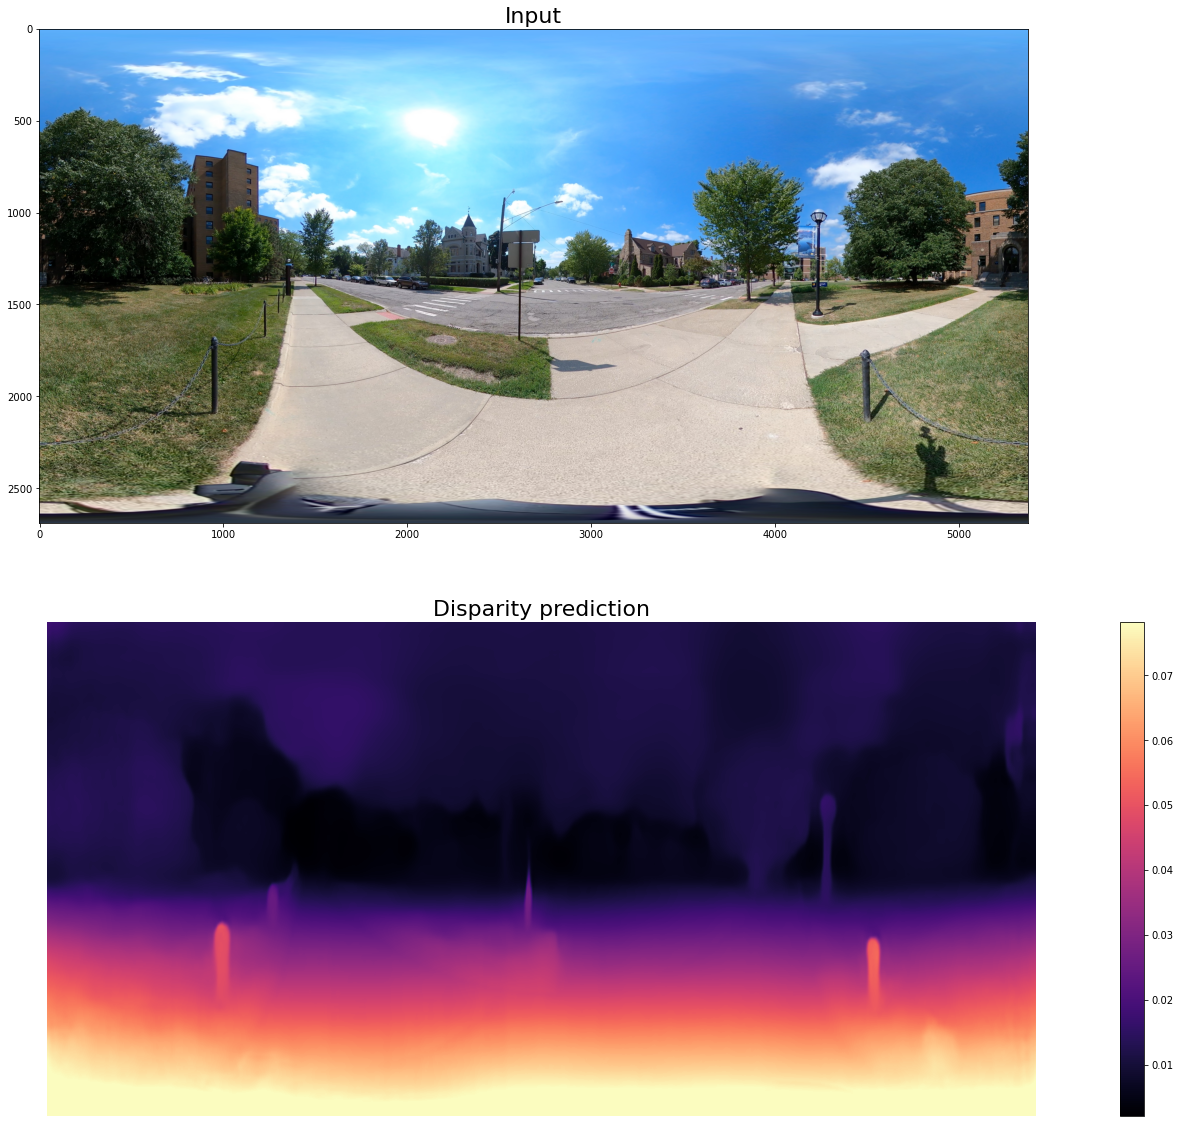

In [ ]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(30, 20))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.colorbar()
plt.axis('off');